<a href="https://colab.research.google.com/github/CPukszta/BI-BE-CS-183-2023/blob/main/HW9/Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bi/Be/Cs 183 2022-2023 Homework 9 Problem 2
In this question, we will get a flavor of stochastic simulations and Bayesian inference. 

In the first part, we will simulate the stochastic model in problem 1 with parameters near the bursty limit. We will compare to the analytical results in problem 1 and see how well the various approximations work.

In the second part, using the simulation data you generated in part I, we will use Markov Chain Monte Carlo method to do Bayesian inference on the parameters. 



## Part I Simulation of stochastic transcription model

In this part, we will use the Gillespie algorithm to run the simulation. The core of the simulation code is already implemented. It remains for you to write the $\textit{propensity functions}$ that determine the instantaneous rates of the reactions. This amounts to writing down the individual contributions to the efflux rates, which we will further explain below.

Let's first take a look at the code.

### Core simulation code: Gillespie algorithm

In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%config InlineBackend.figure_format = 'retina'

!pip install iqplot
import iqplot

import bokeh.io
import bokeh.plotting

bokeh.io.output_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This is the core of the simulation code, a vectorized version of the procedure described in [Gillespie (1976)](https://www.sciencedirect.com/science/article/pii/0021999176900413). You do not need to make any changes to this, but you should be aware of the following conventions for inputs and outputs:

`k`: vector of reaction rates.

`tvec`: strictly increasing vector of observation times, length $n$.

`S`: stochichiometry matrix, size $n_r \times n_s$, where $n_r$ is the number of reactions and $n_s$ is the number of species. Tracks the changes in species amounts due to each reaction.

`nCells`: integer number of cells to simulate.

`propfun`: a function that defines the _propensities_ of reactions enumerated in `S`. As described in lecture, the propensities are instantaneous rates that govern the reaction waiting times.

In [2]:
def gillvec(k,tvec,S,nCells,propfun):
    n_species = S.shape[1]

    num_t_pts = len(tvec)
    X_mesh = np.zeros((nCells,num_t_pts,n_species),dtype=int) #change to float if storing floats!!!!!!! 

    t = np.zeros(nCells,dtype=float)
    tindex = np.zeros(nCells,dtype=int)

    #initialize state: integer unspliced, integer spliced 
    X = np.zeros((nCells,n_species),dtype=int)

	#initialize list of cells that are being simulated
    activecells = np.ones(nCells,dtype=bool)
    while any(activecells):
        mu = np.zeros(nCells,dtype=int)
        n_active_cells = np.sum(activecells)		
        (dt,mu_upd) = rxn_calculator(X[activecells,:],k,propfun)

        t[activecells] += dt
        mu[activecells] = mu_upd

        update = np.zeros(nCells,dtype=bool)
        update[activecells] = t[activecells] > tvec[tindex[activecells]]
        while np.any(update):
            X_mesh[update,tindex[update],:] = X[update]
            tindex += update
            ended_in_update = (tindex==num_t_pts) #less efficient
            if np.any(ended_in_update):
                activecells[ended_in_update] = False
                mu[ended_in_update] = 0
                if not np.any(activecells):
                    print('end simulation')
                    break
            update = np.zeros(nCells,dtype=bool)
            update[activecells] = t[activecells]>tvec[tindex[activecells]]
        # not_burst = mu > 1
        # burst = mu == 1

        X[activecells] += S[mu[activecells]-1]
		# if np.any(burst):		
		# 	bs_rxn = np.random.geometric(1/(1+bs),size=sum(burst))-1	
		# 	addn = np.zeros((sum(burst),n_species),dtype='int')	 
		# 	addn[:,0] = bs_rxn
		# 	X[burst] += addn
    return X_mesh

def rxn_calculator(X,k,propfun):
	nRxn = len(k)
	nCells = X.shape[0]

	a = np.zeros((nCells,nRxn),dtype=float)
 ################################
	a = propfun(a, k, X)
#################################
	a0 = np.sum(a,1)
	dt = np.log(1./np.random.rand(nCells)) / a0
	r2ao = a0 * np.random.rand(nCells)
	mu = np.sum(np.matlib.repmat(r2ao,nRxn+1,1).T >= np.cumsum(np.matlib.hstack((np.zeros((nCells,1)),a)),1) ,1)
	# print(mu)
	return (dt,mu)



### Example: Constitutive production of two independent genes



You will need to write down `propfun` functions, which take in a `k` array, defining the parameters, and an `x` array, defining the current state.

As an example, you could imagine simulating a system with two independent constitutively produced RNA species with transcription rates $k_{1}, k_{2}$ and degradation rates $\gamma_1, \gamma_2$:
$$
\varnothing \xrightarrow{k_1} \mathcal{T}_1 \xrightarrow{\gamma_1} \varnothing\\
\varnothing \xrightarrow{k_2} \mathcal{T}_2 \xrightarrow{\gamma_2} \varnothing
$$
Then `x[0]` will give the copy number of the first mRNA and `x[1]` will report the copy number of the second RNA. The `k` array will be `[k1, k2, g1, g2]`. There are two species and four reactions. We can list them out in order (birth of RNA 1, death of RNA 1, birth of RNA 2, death of RNA 2), along with their effects on the RNA numbers.

The stoichiometry matrix will take the following form:
$$\begin{bmatrix} 1 & 0 \\ -1 & 0 \\ 0 & 1 \\ 0 & -1\end{bmatrix}$$

As expected, the birth (transcription) reactions add 1 to the count of the corresponding RNA; the death reactions subtract 1 from the count.

The propensity function will take the following form:

```
def propfun_indep(a,k,x):
    k1, k2, g1, g2 = k
    ...
    #######
    #fill in this part
    a[0] = k1
    a[1] = g1 * x[0]
    a[2] = k2 
    a[3] = g2 * x[1]
    #######
    ...
    return a
```



Let's try this worked example. First, fill in the propensities, so that the rate of each reaction is correctly described by the amounts of the reactants.

In [3]:
S = np.array([[1,0],[-1,0],[0,1],[0,-1]])
def propfun_indep(a,k,x):
    k1, k2, g1, g2 = k
    x = x.T
    a = a.T
    #######
    #fill in this part
    a[0] = k1
    a[1] = g1 * x[0]
    a[2] = k2 
    a[3] = g2 * x[1]
    #######
    a = a.T
    return a

Initialize the parameter values. (Please do not change these).

In [4]:
T = 5
k = [1,2, 0.75,0.15]
k1, k2, g1, g2 = k
measure_time = T/min(k)

Simulate a single trajectory to equilibrium.

end simulation


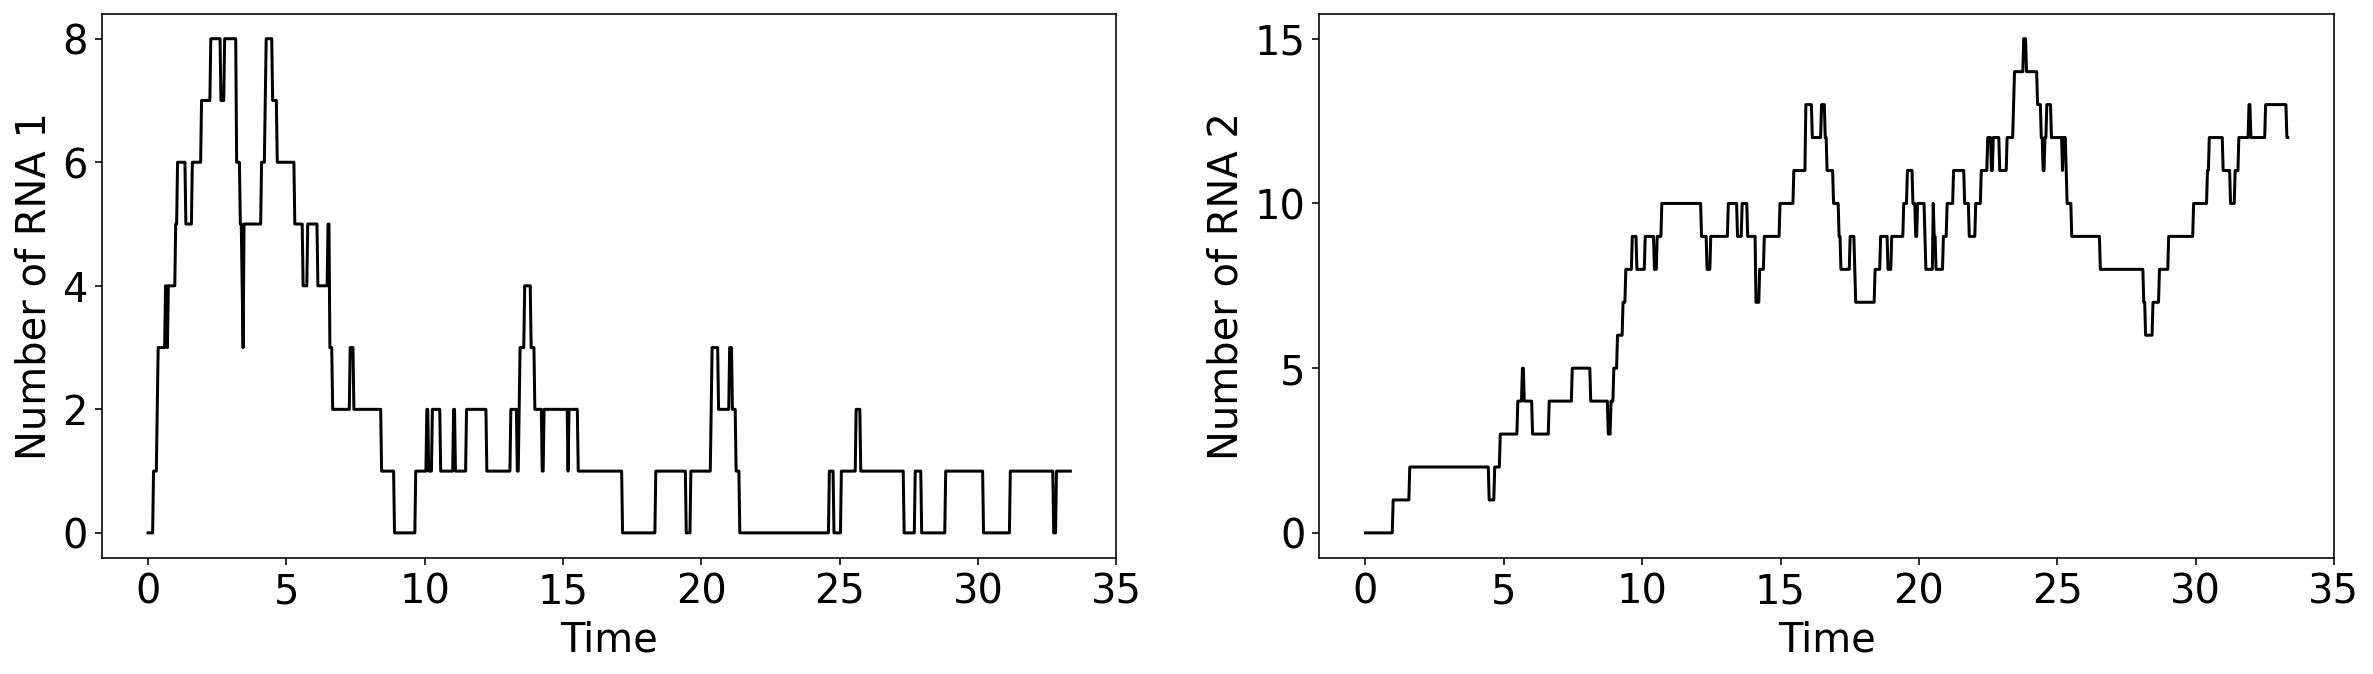

In [5]:
fs = 20
tvec = np.linspace(0,measure_time,1000,endpoint=True)
nCells = 1
X=gillvec(k,tvec,S,nCells,propfun_indep) 

fig1,ax1=plt.subplots(nrows=1,ncols=2,figsize=(20,5))

ax1[0].plot(tvec,X[0,:,0],alpha=1,color='k')
ax1[0].set_xlabel('Time',fontsize=fs)
ax1[0].set_ylabel('Number of RNA 1',fontsize=fs)
ax1[0].tick_params(axis='y',labelsize=fs)
ax1[0].tick_params(axis='x',labelsize=fs)

ax1[1].plot(tvec,X[0,:,1],alpha=1,color='k')
ax1[1].set_xlabel('Time',fontsize=fs)
ax1[1].set_ylabel('Number of RNA 2',fontsize=fs)
ax1[1].tick_params(axis='x',labelsize=fs)
ax1[1].tick_params(axis='y',labelsize=fs)

### (a) Use the code layout provided to make a function that calculates reaction rates for the Stochastic transcription model in Problem 1. 

Using the above example as a template, we would like to simulate a more complex process with a regulated gene locus:

\begin{split}
I &\xrightarrow{k_{on}} A\\
A &\xrightarrow{k_{off}} I\\
A &\xrightarrow{k_A} A + \mathcal{T}\\
\mathcal{T} &\xrightarrow{\gamma} \varnothing
\end{split}

Write down the stoichiometry matrix for the gene locus/RNA system.

In [6]:
#columns: [gene_state,Tau] rows: [kon,koff,kA,gamma]
S = np.array([[1,0],[-1,0],[0,1],[0,-1]])

Make sure to get an intuition for this. There are four reactions: gene activation, gene inhibition, RNA production from an activated gene, RNA degradation. There are two "species" affected by the reactions: the gene state, which only takes on values in $\{0,1\}$, and the number of RNA, which can be any integer in $\mathbb{N}_0$. 

The parameters are $k_{on}$, $k_{off}$, $k_{A}$, and $\gamma$. The inputs are $X$, the current state of the random telegraph process (inactive if zero, active if one), and $N$, the number of RNA molecules. The outputs are the propensities of the following reactions: activation, deactivation, transcription from active state, degradation.

Now, write down the propensity functions corresponding to these four reactions. The input to the function `propfun` will include `k`, defined as the vector of $k_{on}, k_{off}, k_A, \gamma$ (named in more descriptive terms in the first line of the code proper). 

You need to define each entry of the vector `a` as a function of the parameter values and the entries of `x`. The entries of `a` are propensities of the four reactions. The entries of `x` are the species (gene state and mRNA count).

In [7]:
def propfun_gene(a,k,x):
    kon, koff, ka, kdeg = k
    x = x.T
    a = a.T
    #######
    a[0] = kon * (1-x[0])
    a[1] = koff *x[0]
    a[2] = ka * x[0]
    a[3] = kdeg * x[1]

    #######
    a = a.T

    return a

### (b) Simulate the process and compare your results to the pre-defined negative binomial approximation (the Bursty limit).

We will begin with the bursty regime of the telegraph model of transcription. Now run the simulaiton for 1000 cells with paramters defined below. ```measure_time``` is the simulation time.


In [8]:
T = 5
k = [1, 100, 100, 2]
kon, koff, ka, kdeg = k
measure_time = T/min(k)

In [9]:
fs = 20
tvec = np.linspace(0,measure_time,1000,endpoint=True)
nCells = 1000
X=gillvec(k,tvec,S,nCells,propfun_gene) 

end simulation


In [10]:
from bokeh.layouts import row

#lets plot one of the simulations and see what it looks like!
p = bokeh.plotting.figure(width = 400, height = 350,
                          title = "Stocastic Transcription model RNA Transcripts",
                          x_axis_label = "Time", y_axis_label="# of RNA")

q = bokeh.plotting.figure(width = 400, height = 350,
                          title = "Stocastic Transcription model Hidden State",
                          x_axis_label = "Time", y_axis_label="Hidden State")

color =  bokeh.palettes.Dark2[5]

for i in range(4):
  num = i+1
  legend_title = "Simulation {}.".format(num)
  p.line(tvec,X[i,:,1],color=color[i],line_width=2, legend_label =legend_title )
  q.line(tvec,X[i,:,0],color=color[i],line_width=2, legend_label = legend_title)

p.legend.click_policy = "hide"
q.legend.click_policy = "hide"

bokeh.io.show(row(p,q))

Compared to the bursty limit, this is ceritanly a lot less total number of RNA produced. It looks much more like the 1st RNA producition in the bursty limit than the 2nd RNA which is most likley a consequence of the rate perameters

## Part II Bayesian inference

In the bursty limit, we know the solution is a negative binomial distribution specified by parameters r and θ from Problem 1d. In this part, you will use a Bayesian inference package pymc to infer the parameters (pretending we don't know) using the simulation data you generated in part I.

In our Bayesian statistical models of the data, we first define a prior distribution for each parameter and then run Markov chain Monte Carlo (MCMC) to get the posterior distributions of them. You will provide an example below. For further details, you can see [here](https://www.stats.ox.ac.uk/~reinert/mcmc/mcmc.pdf)

We first install the [pymc](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html) package and load a few necessary packages.

In [11]:
!pip install pymc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt

# PyMC-related imports
import pymc as pm

# Plotting
import matplotlib.pyplot as plt
import arviz as az
import matplotlib as mpl

# Timer
import time as ti

/usr/local/lib/python3.9/dist-packages/arviz/__init__.py:317: UserWarning: Trying to register the cmap 'cet_gray' which already exists.
  register_cmap("cet_" + name, cmap=cmap)
/usr/local/lib/python3.9/dist-packages/arviz/__init__.py:317: UserWarning: Trying to register the cmap 'cet_gray_r' which already exists.
  register_cmap("cet_" + name, cmap=cmap)


### Example: fitting the mean of a Poission distribution

In [13]:
# generate data points from a Poisson distribution
data = np.random.poisson(lam=10,size=1000)

**We first define the model**

In [14]:
# initialize pymc model
model = pm.Model()

# define the model
with model:
    # Specify the Priors of the mean lam
    l = pm.LogNormal('l', mu=0, sigma=1)
    # observed data follow a Poisson distribution with mean lam
    x = pm.Poisson('x', mu=l, observed=data)

**Then we fit the model through Mante Carlo sampling**

In [15]:
# fit the model
with model:
    # run two Markov chains using two cores
    trace = pm.sample(draws = 1000, chains = 2, cores = 2)

In [16]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

**The trace you get from ```sample``` records all the information about the 1000 draws from the two chains (2000 samples in total). To get values of parameter 'l' (the lambda), you can call ```trace.posterior['l']```. For example, let's calculate the posterior mean of parameter ```l```**

In [17]:
#  posterior mean
with model:
    print(trace.posterior["l"].mean())

<xarray.DataArray 'l' ()>
array(9.92873522)


### (a) Now infer the values of parameters r and θ in Problem 1d using the simulation data you generated in part I. Plot the posterior distribution of all parameters, i.e., plot a histogram of the values of each parameter stored in trace. 

For priors, you can use
```
r = pm.LogNormal('r', mu=0, sigma=1)
b = pm.LogNormal('theta', mu=0, sigma=1)
```



In [18]:
# Use the data points generated above
data = X[:,-1,1]

# initialize pymc model
model = pm.Model()

# define the model
with model:
    # Specify the Priors of r and b
    r = pm.LogNormal('r', mu=0, sigma=1)
    b = pm.LogNormal('theta', mu=0, sigma=1)
    # observed data follow a negative binomial
    x = pm.NegativeBinomial('x', p=(b/(1+b)),n=r, observed=data)

# fit the model
with model:
    # run two Markov chains using two cores
    trace = pm.sample(draws = 1000, chains = 2, cores = 2)

In [19]:
r_calc = trace.posterior['r']
theta_calc = trace.posterior['theta']

In [20]:
r_hist = iqplot.histogram(data=np.concatenate(r_calc),title="r Values Histogram",style='step_filled',palette ="#fc8d59",frame_width=550)
theta_hist = iqplot.histogram(data=np.concatenate(theta_calc),title="Theta Values Histogram",style='step_filled',palette ="#91bfdb",frame_width=550)


bokeh.io.show(row(r_hist,theta_hist))

### (b) Randomly choose only 100 data points and infer the values of parameters r and θ again. Plot the posteriors and compare to the results in (a)

In [21]:
#randomly choose 100 data points
#choose a seed and generate 100 values between 1 and 999
from numpy import random
np.random.seed(14675)
#lets choose 100 indicies and grab just those indicies from the matrix
inds = random.choice(np.linspace(0,999,1000),size=100, replace = False)
inds = inds.astype(int)
data_r100 = X[inds,-1,1]

# initialize pymc model
model = pm.Model()

# define the model
with model:
    # Specify the Priors of r and b
    r = pm.LogNormal('r', mu=0, sigma=1)
    b = pm.LogNormal('theta', mu=0, sigma=1)
    # observed data follow a negative binomial
    x = pm.NegativeBinomial('x', p=(b/(1+b)),n=r, observed=data_r100)

# fit the model
with model:
    # run two Markov chains using two cores
    trace = pm.sample(draws = 1000, chains = 2, cores = 2)

r_calc_r100 = trace.posterior['r']
theta_calc_r100 = trace.posterior['theta']

r_hist_r100 = iqplot.histogram(data=np.concatenate(r_calc_r100),title="r Values Histogram",style='step_filled',palette ="#fc8d59",frame_width=550)
theta_hist_r100 = iqplot.histogram(data=np.concatenate(theta_calc_r100),title="Theta Values Histogram",style='step_filled',palette ="#91bfdb",frame_width=550)


bokeh.io.show(row(r_hist_r100,theta_hist_r100))

If we have less samples, the estimate for both r and $\theta$ gets a lot more spread out with more outliers. This makes sense in the bursty model because we will see more bursts with more samples which will make our estimates of the peramters better.

Our analytical values for the two perameters are:

$p = \frac{k_{on}}{k_{off}+k_{on}} = \frac{1}{101}$

$\theta = \frac{p}{1-p} ≈0.99 $

$r = \frac{k_{on}}{\gamma} = 0.5$

When using 1000 samples, we are pretty spot on to estimating these values, but when we use onle 100 samples, the estimates are not quite as good.